In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset/movies.csv
/kaggle/input/imdb-dataset/ratings.csv
/kaggle/input/imdb-dataset/users.csv
/kaggle/input/imdb-dataset/reviews.csv


<h1> Factorization Machine Recommender System <h1>

Import lib

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter


# 1. Read Dataset

In [3]:
df_movies = pd.read_csv('/kaggle/input/imdb-dataset/movies.csv')
df_movies.head()

,ID,Title,Genres,Rating,Year,Numrate,Runtime,Image,Directors,Writers,Stars
0,tt0283530,The Emperor's Club,Drama,6.9,2002,18K,109,https://m.media-amazon.com/images/M/MV5BZmNlNz...,Michael Hoffman,"Ethan Canin, Neil Tolkin","Kevin Kline, Emile Hirsch, Joel Gretsch"
1,tt6859762,The Little Stranger,"Drama, Horror, Mystery",5.5,2018,11K,111,https://m.media-amazon.com/images/M/MV5BMTYyNz...,Lenny Abrahamson,"Lucinda Coxon, Sarah Waters","Domhnall Gleeson, Will Poulter, Ruth Wilson"
2,tt1196204,Cemetery Junction,"Comedy, Drama",6.8,2010,24K,95,https://m.media-amazon.com/images/M/MV5BMTQ1Mj...,"Ricky Gervais, Stephen Merchant","Ricky Gervais, Stephen Merchant","Christian Cooke, Felicity Jones, Tom Hughes"
3,tt3463106,The Cured,"Zombie Horror, Drama, Horror, Sci-Fi, Thriller",5.6,2017,9.8K,95,https://m.media-amazon.com/images/M/MV5BMmIwOD...,David Freyne,David Freyne,"Elliot Page, Sam Keeley, Tom Vaughan-Lawlor"
4,tt1023490,Il Divo,"Biography, Drama",7.2,2008,20K,110,https://m.media-amazon.com/images/M/MV5BZTJhZT...,Paolo Sorrentino,Paolo Sorrentino,"Toni Servillo, Anna Bonaiuto, Giulio Bosetti"


In [4]:
df_reviews = pd.read_csv('/kaggle/input/imdb-dataset/reviews.csv')
df_reviews.head()

,MovieID,Rating,Username,CommentDate
0,tt0283530,7,CuriosityKilledShawn,"Aug 14, 2005"
1,tt0283530,7,ma-cortes,"Jul 12, 2005"
2,tt0283530,8,redkiwi,"Dec 9, 2002"
3,tt0283530,9,KUAlum26,"Mar 20, 2006"
4,tt0283530,10,au_law2001,"Jan 23, 2005"


In [5]:
df_ratings = pd.read_csv('/kaggle/input/imdb-dataset/ratings.csv')
df_ratings.head()

,MovieID,Rating,Username,CommentDate
0,tt2096673,10.0,bretttaylor-04022,"Rated on Jun 10, 2017"
1,tt0434409,8.0,bretttaylor-04022,"Rated on Jun 10, 2017"
2,tt1205489,9.0,bretttaylor-04022,"Rated on Jun 10, 2017"
3,tt0266543,8.0,bretttaylor-04022,"Rated on Jun 10, 2017"
4,tt0758758,8.0,bretttaylor-04022,"Rated on Jun 10, 2017"


# 2. Exploring Data

## 2.1 Drop duplicates

In [6]:
df_movies.drop_duplicates(inplace=True)
df_reviews.drop_duplicates(inplace=True)
df_ratings.drop_duplicates(inplace=True)

## 2.2 Describe Data and Handling Missing Values

**MOVIES**

In [7]:
df_movies.describe()

,Rating,Year,Runtime
count,6675.000000,6675.000000,6675.000000
mean,6.348899,2013.149363,107.705768
std,0.973587,6.789507,19.327470
min,1.200000,2000.000000,47.000000
25%,5.700000,2008.000000,94.000000
50%,6.400000,2014.000000,104.000000
75%,7.000000,2019.000000,117.000000
max,9.000000,2024.000000,467.000000


In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6675 entries, 0 to 6674
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         6675 non-null   object 
 1   Title      6675 non-null   object 
 2   Genres     6675 non-null   object 
 3   Rating     6675 non-null   float64
 4   Year       6675 non-null   int64  
 5   Numrate    6675 non-null   object 
 6   Runtime    6675 non-null   int64  
 7   Image      6675 non-null   object 
 8   Directors  6675 non-null   object 
 9   Writers    6674 non-null   object 
 10  Stars      6619 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 573.8+ KB


Fill nan value on columns (Directors, Writers, Stars) by ''

In [9]:
df_movies.fillna(value = '',inplace = True)

**REVIEWS**

In [10]:
df_reviews.describe()

,Rating
count,190643.000000
mean,6.137986
std,2.570391
min,1.000000
25%,4.000000
50%,7.000000
75%,8.000000
max,10.000000


In [11]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190643 entries, 0 to 190642
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   MovieID      190643 non-null  object
 1   Rating       190643 non-null  int64 
 2   Username     190643 non-null  object
 3   CommentDate  190643 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.8+ MB


Convert columns CommentDate

In [12]:
df_reviews['CommentDate'] = pd.to_datetime(df_reviews['CommentDate'])
df_reviews.head()

,MovieID,Rating,Username,CommentDate
0,tt0283530,7,CuriosityKilledShawn,2005-08-14
1,tt0283530,7,ma-cortes,2005-07-12
2,tt0283530,8,redkiwi,2002-12-09
3,tt0283530,9,KUAlum26,2006-03-20
4,tt0283530,10,au_law2001,2005-01-23


**RATINGS**

In [13]:
df_ratings.describe()

,Rating
count,1.380601e+06
mean,6.396743e+00
std,2.124442e+00
min,1.000000e+00
25%,5.000000e+00
50%,7.000000e+00
75%,8.000000e+00
max,1.000000e+01


In [14]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380657 entries, 0 to 1380656
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   MovieID      1380657 non-null  object 
 1   Rating       1380601 non-null  float64
 2   Username     1380657 non-null  object 
 3   CommentDate  1380601 non-null  object 
dtypes: float64(1), object(3)
memory usage: 42.1+ MB


Drop NaN value in columns: MovieID, Rating, Username

In [15]:
df_ratings.dropna(subset=['Username', 'Rating', 'MovieID'], inplace = True)
df_ratings['CommentDate'] = df_ratings['CommentDate'].fillna('Rated on Jun 1, 2000')

Convert Column CommentDate 

In [16]:
df_ratings['CommentDate'] = df_ratings['CommentDate'].str.replace("Rated on ", "", regex=False)
df_ratings['CommentDate'] = pd.to_datetime(df_ratings['CommentDate'])
df_ratings.head()

,MovieID,Rating,Username,CommentDate
0,tt2096673,10.0,bretttaylor-04022,2017-06-10
1,tt0434409,8.0,bretttaylor-04022,2017-06-10
2,tt1205489,9.0,bretttaylor-04022,2017-06-10
3,tt0266543,8.0,bretttaylor-04022,2017-06-10
4,tt0758758,8.0,bretttaylor-04022,2017-06-10


## 2.2 Merge Reviews and Ratings

Filter ratings and reviews

In [17]:
movieIDs = df_movies['ID']
df_reviews =  df_reviews[df_reviews['MovieID'].isin(movieIDs)]
df_ratings =  df_ratings[df_ratings['MovieID'].isin(movieIDs)]
print(df_reviews.shape[0], df_ratings.shape[0])

190643 1130658


Merge

In [18]:
ratings = pd.concat([df_reviews, df_ratings], ignore_index = True)
ratings.drop_duplicates(subset=['Username', 'MovieID'], inplace = True)
print(ratings)

           MovieID  Rating              Username CommentDate
0        tt0283530     7.0  CuriosityKilledShawn  2005-08-14
1        tt0283530     7.0             ma-cortes  2005-07-12
2        tt0283530     8.0               redkiwi  2002-12-09
3        tt0283530     9.0              KUAlum26  2006-03-20
4        tt0283530    10.0            au_law2001  2005-01-23
...            ...     ...                   ...         ...
1321296  tt1821549     9.0              seaview1  2014-03-01
1321297  tt0790636     9.0              seaview1  2014-03-01
1321298  tt2431286     9.0              seaview1  2014-03-01
1321299  tt1843866     9.0              seaview1  2014-04-18
1321300  tt1877832     9.0              seaview1  2014-06-12

[1269661 rows x 4 columns]


In [19]:
numUser = ratings['Username'].copy()
numUser.drop_duplicates(inplace = True)
print("Total Users:", numUser.shape[0])
print("Total Movies:", df_movies.shape[0])
print("Total Ratings:", ratings.shape[0])

Total Users: 14148
Total Movies: 6675
Total Ratings: 1269661


## 2.3 Statistical Analysis and Preprocesing Data

### 2.3.0 Ratings

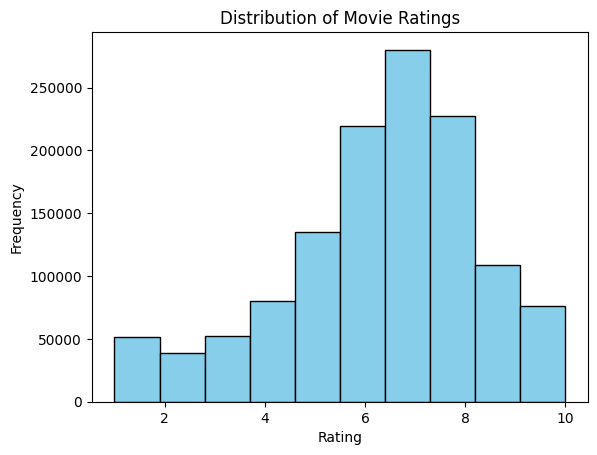

In [20]:
plt.hist(ratings['Rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

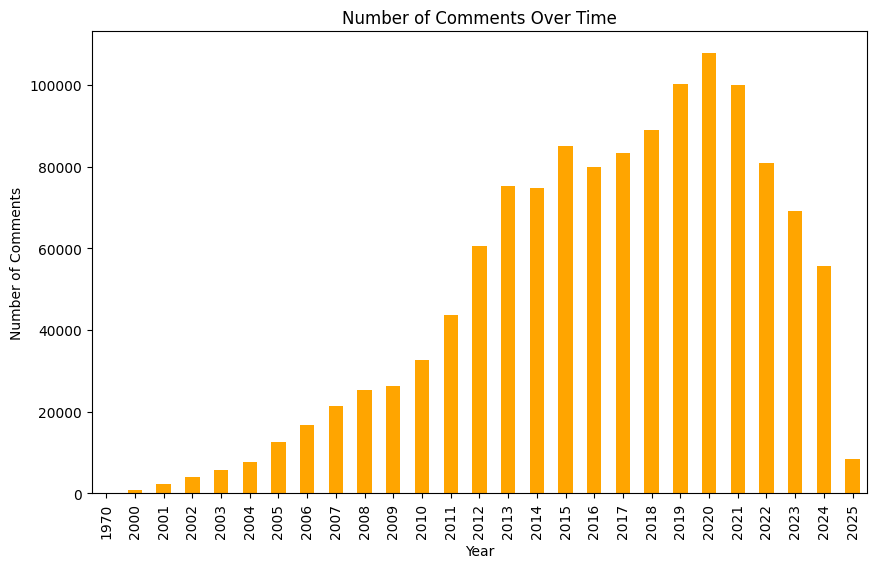

In [21]:
ratings['Year'] = ratings['CommentDate'].dt.to_period('Y')
comments_over_time = ratings.groupby('Year').size()

comments_over_time.plot(kind='bar', color='orange', figsize=(10, 6))
plt.title('Number of Comments Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.show()

In [22]:
ratings['CommentDate'].describe()

count                          1269661
mean     2017-01-19 18:09:38.847424768
min                1970-01-01 00:00:00
25%                2013-10-09 00:00:00
50%                2017-09-28 00:00:00
75%                2020-12-23 00:00:00
max                2025-04-07 00:00:00
Name: CommentDate, dtype: object

In [23]:
ratings['CommentDate'] = ratings['CommentDate'].apply(lambda x: 
    pd.Timestamp('2000-01-01') if x.year < 2000 
    else pd.Timestamp('2024-12-31') if x.year > 2024 
    else x
)

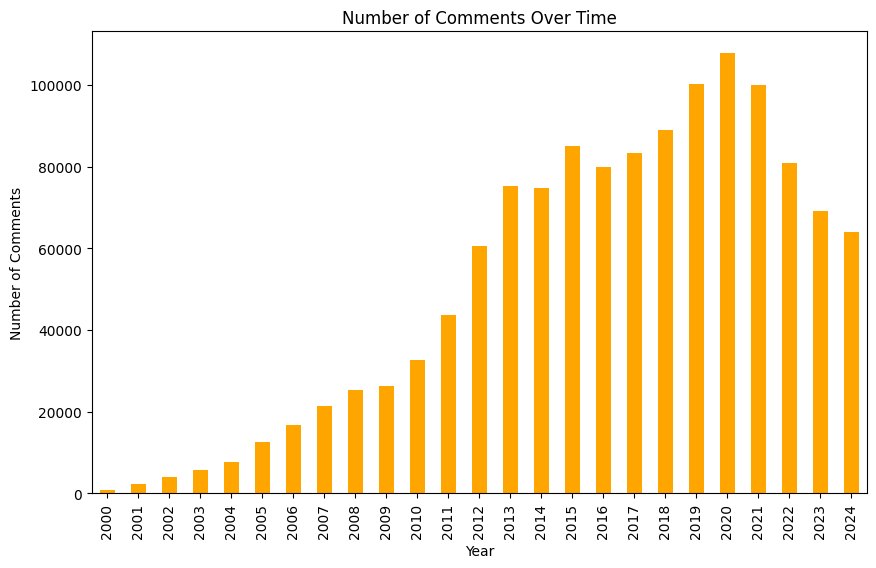

In [24]:
ratings['Year'] = ratings['CommentDate'].dt.to_period('Y')
comments_over_time = ratings.groupby('Year').size()

comments_over_time.plot(kind='bar', color='orange', figsize=(10, 6))
plt.title('Number of Comments Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.show()

### 2.3.1 Users 

In [25]:
list_usernames = ratings["Username"].unique().tolist()
print(list_usernames[:10])

['CuriosityKilledShawn', 'ma-cortes', 'redkiwi', 'KUAlum26', 'au_law2001', 'August1991', 'helpless_dancer', 'FilmOtaku', 'ferguson-6', 'Beachbum2018']


Visual Gender

1: Male, 0: Female

In [26]:
user_df = pd.DataFrame(list_usernames, columns=["Username"])
np.random.seed(42)
user_df["Gender"] = np.random.choice(["Male", "Female"], size=len(user_df), p=[0.7, 0.3])
user_df

,Username,Gender
0,CuriosityKilledShawn,Male
1,ma-cortes,Female
2,redkiwi,Female
3,KUAlum26,Male
4,au_law2001,Male
...,...,...
14143,briner8397,Male
14144,TeenVamp,Male
14145,mathomas-28053,Male
14146,WolfGoddess77,Male


Visual Age

* 1:  "Under 18"
* 18:  "18-24"
* 25:  "25-34"
* 35:  "35-44"
* 45:  "45-49"
* 50:  "50-55"
* 56:  "56+"

In [27]:
age_values = [ 1, 18, 25, 35, 45, 50, 56]
age_probs  = [ 222, 1103, 2096, 1193,  550,  496,  380]
age_probs = [p / sum(age_probs) for p in age_probs]  # chuyển về tỷ lệ

# Random tuổi theo phân phối
np.random.seed(42)
user_df['Age'] = np.random.choice(age_values, size=len(user_df), p=age_probs)

print(user_df)
age_proportions = user_df['Age'].value_counts(normalize=True) * 100
print("\nAge Proportions (%):\n", age_proportions)

                   Username  Gender  Age
0      CuriosityKilledShawn    Male   25
1                 ma-cortes  Female   56
2                   redkiwi  Female   35
3                  KUAlum26    Male   35
4                au_law2001    Male   18
...                     ...     ...  ...
14143            briner8397    Male   25
14144              TeenVamp    Male   25
14145        mathomas-28053    Male   35
14146         WolfGoddess77    Male   35
14147             RHPSvegas    Male   25

[14148 rows x 3 columns]

Age Proportions (%):
 Age
25    35.100368
35    19.402036
18    18.688154
45     8.785694
50     8.078880
56     6.325982
1      3.618886
Name: proportion, dtype: float64


Visual Occupation

*  0:  "other" or not specified
*  1:  "academic/educator"
*  2:  "artist"
*  3:  "clerical/admin"
*  4:  "college/grad student"
*  5:  "customer service"
*  6:  "doctor/health care"
*  7:  "executive/managerial"
*  8:  "farmer"
*  9:  "homemaker"
* 10:  "K-12 student"
* 11:  "lawyer"
* 12:  "programmer"
* 13:  "retired"
* 14:  "sales/marketing"
* 15:  "scientist"
* 16:  "self-employed"
* 17:  "technician/engineer"
* 18:  "tradesman/craftsman"
* 19:  "unemployed"
* 20:  "writer"

In [28]:
np.random.seed(42)

user_df['Occupation'] = -1

age_distribution = {
    '<18': {10: 163, 0: 27, 19: 12, 1: 4, 2: 3, 4: 3, 17: 2, 14: 2, 7: 2, 8: 1, 13: 1, 12: 1, 11: 1}, 
    '18-56': {4: 756, 0: 651, 7: 638, 17: 478, 1: 469, 12: 380, 14: 285, 20: 270, 2: 252, 16: 217, 6: 215, 3: 161, 15: 137, 11: 122, 5: 111, 9: 88, 18: 67, 19: 58, 13: 39, 10: 31, 8: 13}, 
    '>56': {13: 102, 1: 55, 7: 39, 0: 33, 16: 24, 17: 22, 6: 21, 14: 15, 3: 12, 2: 12, 20: 11, 12: 7, 15: 7, 11: 6, 9: 4, 18: 3, 8: 3, 19: 2, 5: 1, 10: 1}
}





under18_probs = np.array(list(age_distribution["<18"].values()))
under18_probs = under18_probs / under18_probs.sum()

over56_probs = np.array(list(age_distribution[">56"].values()))
over56_probs = over56_probs / over56_probs.sum()

age18_56_probs = np.array(list(age_distribution["18-56"].values()))
age18_56_probs = age18_56_probs / age18_56_probs.sum()



# <18
age_under18_idx = user_df[user_df['Age'] == 1].index
under18_choices = list(age_distribution["<18"].keys())
user_df.loc[age_under18_idx, 'Occupation'] = np.random.choice(
    under18_choices, size=len(age_under18_idx), p=under18_probs
)




# 56+
age_over56_idx = user_df[user_df['Age'] == 56].index
over56_choices = list(age_distribution[">56"].keys())
user_df.loc[age_over56_idx, 'Occupation'] = np.random.choice(
    over56_choices, size=len(age_over56_idx), p=over56_probs
)



#18-56
age_18_56_idx = user_df[user_df['Age'].isin([18, 25, 35, 45, 50])].index
age18_56_choices = list(age_distribution["18-56"].keys())
user_df.loc[age_18_56_idx, 'Occupation'] = np.random.choice(
    age18_56_choices, size=len(age_18_56_idx), p=age18_56_probs
)

# Calculate occupation proportions
occupation_proportions = user_df['Occupation'].value_counts(normalize=True) * 100
print("\nOccupation Proportions (%):\n", occupation_proportions)
print(user_df.head())


Occupation Proportions (%):
 Occupation
4     12.750919
0     11.923947
7     11.301951
1      8.630195
17     8.616059
12     6.516822
14     4.891151
20     4.580153
2      4.283291
6      3.845066
16     3.830930
10     3.102912
3      2.876732
13     2.431439
15     2.254736
5      2.007351
11     1.865988
9      1.653944
19     1.208651
18     1.109697
8      0.318066
Name: proportion, dtype: float64
               Username  Gender  Age  Occupation
0  CuriosityKilledShawn    Male   25          16
1             ma-cortes  Female   56          15
2               redkiwi  Female   35          12
3              KUAlum26    Male   35           3
4            au_law2001    Male   18           0


In [29]:
user_index_by_username = {username: idx for idx, username in enumerate(list_usernames)}
print("test index: ", user_index_by_username['CuriosityKilledShawn'])
gender_index_by_name = {"Female":0, "Male": 1}
age_index_by_name = {1: 0, 18: 1, 25: 2, 35:3, 45: 4, 50: 5, 56:6}
occupations = list(range(21))
occupation_index_by_name = {name: index for index, name in enumerate(occupations)}

num_users = len(list_usernames)
print("numuser: ",num_users)
gender_offset = num_users
age_offset = gender_offset + len(gender_index_by_name)
occupation_offset = age_offset + len(age_index_by_name)

user_features = []

for index in range(num_users):
    gender_index = gender_index_by_name[user_df["Gender"][index]] + gender_offset
    age_index = age_index_by_name[user_df["Age"][index]] + age_offset
    occupation_index = user_df["Occupation"][index] + occupation_offset
    user_features.append([index, gender_index, age_index, occupation_index])


print("Example for briner8397: ", user_features[user_index_by_username["briner8397"]])

test index:  0
numuser:  14148
Example for briner8397:  [14143, 14149, 14152, 14158]


### 2.3.2 Movies

In [30]:
df_movies.columns

Index(['ID', 'Title', 'Genres', 'Rating', 'Year', 'Numrate', 'Runtime',
       'Image', 'Directors', 'Writers', 'Stars'],
      dtype='object')

Drop unneeded columns

In [31]:
df_movies = df_movies.drop(['Title', 'Rating', 'Image', 'Numrate'], axis = 1)
df_movies.head(1)

,ID,Genres,Year,Runtime,Directors,Writers,Stars
0,tt0283530,Drama,2002,109,Michael Hoffman,"Ethan Canin, Neil Tolkin","Kevin Kline, Emile Hirsch, Joel Gretsch"


In [32]:
movie_index_by_id = {movie_id: idx for idx, movie_id in enumerate(df_movies['ID'])}

print("Ví dụ ánh xạ MovieID với index:", movie_index_by_id['tt0283530'])

Ví dụ ánh xạ MovieID với index: 0


**Genres**

Clean and Onehot encoding

In [33]:
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: [g.strip().lower() for g in x.split(',')])
df_movies['Genres'].head(100)

0                                               [drama]
1                              [drama, horror, mystery]
2                                       [comedy, drama]
3      [zombie horror, drama, horror, sci-fi, thriller]
4                                    [biography, drama]
                            ...                        
95    [psychological thriller, road trip, drama, mys...
96                   [slasher horror, horror, thriller]
97    [coming-of-age, feel-good romance, comedy, dra...
98                 [coming-of-age, period drama, drama]
99                                    [comedy, romance]
Name: Genres, Length: 100, dtype: object

In [34]:
genre_counter = Counter()
for genre_list in df_movies['Genres']:
    for genre in genre_list:
        genre_counter[genre] += 1
len(genre_counter)

183

In [35]:
rare_genres = {genre for genre, count in genre_counter.items() if count < 20}
# print("Thể loại hiếm:", rare_genres)

In [36]:
def replace_rare_genres(genre_list):
    new_list = []
    for genre in genre_list:
        if genre in rare_genres: 
            new_list.append('other')
        else:
            new_list.append(genre)
    return sorted(set(new_list))  # Loại bỏ trùng lặp và sắp xếp lại

df_movies['Genres'] = df_movies['Genres'].apply(replace_rare_genres)
print(df_movies['Genres'].head(10))

0                                              [drama]
1                             [drama, horror, mystery]
2                                      [comedy, drama]
3     [drama, horror, sci-fi, thriller, zombie horror]
4                                   [biography, drama]
5                                   [action, thriller]
6    [crime, dark comedy, horror, psychological thr...
7    [adventure, comedy, family, fantasy, road trip...
8                   [comedy, romance, romantic comedy]
9                                       [drama, music]
Name: Genres, dtype: object


In [37]:
# Danh sách tất cả các thể loại duy nhất (bao gồm cả 'other')
all_genres = set()
for genre_list in df_movies['Genres']:
    all_genres.update(genre_list)

# Sắp xếp và tạo ra chỉ số cho từng thể loại
genre_index_by_name = {genre: idx for idx, genre in enumerate(sorted(all_genres))}

# In ra genre_index_by_name để kiểm tra
# print("Genre Index Mapping:", genre_index_by_name)

**Year**

In [38]:
def group_years(year):
    return (year // 5) * 5

df_movies['Year_Group'] = df_movies['Year'].apply(group_years)

print(df_movies[['ID', 'Year', 'Year_Group']].head(10))
df_movies.drop(['Year'], axis = 1, inplace = True)
df_movies.head(1)

          ID  Year  Year_Group
0  tt0283530  2002        2000
1  tt6859762  2018        2015
2  tt1196204  2010        2010
3  tt3463106  2017        2015
4  tt1023490  2008        2005
5  tt1547234  2012        2010
6  tt0804516  2007        2005
7  tt0131704  2000        2000
8  tt0261289  2002        2000
9  tt0365957  2004        2000


,ID,Genres,Runtime,Directors,Writers,Stars,Year_Group
0,tt0283530,[drama],109,Michael Hoffman,"Ethan Canin, Neil Tolkin","Kevin Kline, Emile Hirsch, Joel Gretsch",2000


In [39]:
# Lấy tất cả các nhóm năm (Year_Group) duy nhất
year_groups = df_movies['Year_Group'].unique()

# Tạo từ điển ánh xạ từ nhóm năm sang chỉ số
year_index_by_group = {year_group: idx for idx, year_group in enumerate(sorted(year_groups))}

# In ra year_index_by_group để kiểm tra
print("Year Group Index Mapping:", year_index_by_group)

Year Group Index Mapping: {2000: 0, 2005: 1, 2010: 2, 2015: 3, 2020: 4}


**Runtime**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


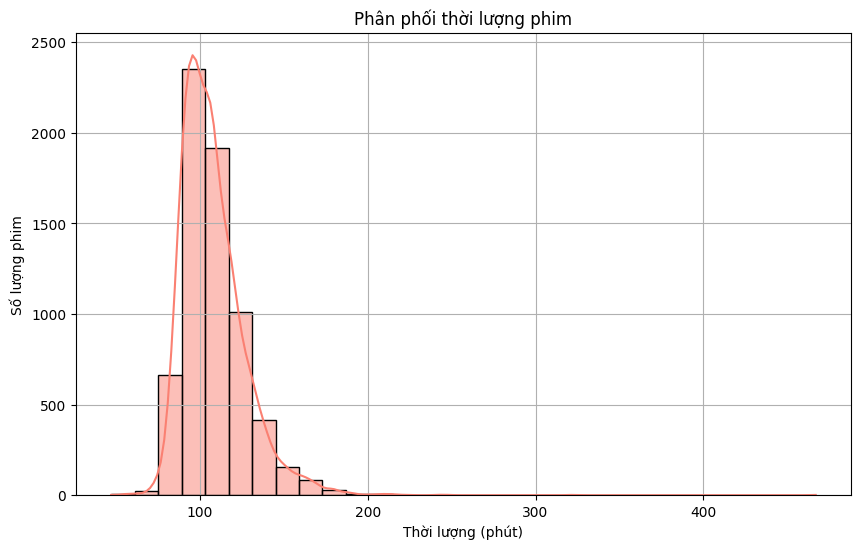

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_movies, x='Runtime', bins=30, kde=True, color='salmon')
plt.title('Phân phối thời lượng phim')
plt.xlabel('Thời lượng (phút)')
plt.ylabel('Số lượng phim')
plt.grid(True)
plt.show()

In [41]:
df_movies['Runtime'].describe()

count    6675.000000
mean      107.705768
std        19.327470
min        47.000000
25%        94.000000
50%       104.000000
75%       117.000000
max       467.000000
Name: Runtime, dtype: float64

In [42]:
def group_runtime(runtime):
    if runtime < 60:
        return 'Very_Short'
    elif runtime < 90:
        return 'Short'
    elif runtime < 120:
        return 'Standard'
    elif runtime < 150:
        return 'Long'
    else:
        return 'Very_Long'

df_movies['Runtime_group'] = df_movies['Runtime'].apply(group_runtime)
df_movies.drop(['Runtime'], axis=1, inplace=True)
df_movies.head(2)

,ID,Genres,Directors,Writers,Stars,Year_Group,Runtime_group
0,tt0283530,[drama],Michael Hoffman,"Ethan Canin, Neil Tolkin","Kevin Kline, Emile Hirsch, Joel Gretsch",2000,Standard
1,tt6859762,"[drama, horror, mystery]",Lenny Abrahamson,"Lucinda Coxon, Sarah Waters","Domhnall Gleeson, Will Poulter, Ruth Wilson",2015,Standard


In [43]:
# Lấy tất cả các nhóm thời gian (Runtime_group) duy nhất
runtime_groups = df_movies['Runtime_group'].unique()

# Tạo từ điển ánh xạ từ nhóm thời gian sang chỉ số
runtime_index_by_group = {runtime_group: idx for idx, runtime_group in enumerate(sorted(runtime_groups))}

# In ra runtime_index_by_group để kiểm tra
print("Runtime Group Index Mapping:", runtime_index_by_group)

Runtime Group Index Mapping: {'Long': 0, 'Short': 1, 'Standard': 2, 'Very_Long': 3, 'Very_Short': 4}


**Directors**

In [44]:
df_movies['Directors'] = df_movies['Directors'].apply(lambda x: [g.strip().lower() for g in x.split(',')])
df_movies['Directors'].head(5)

0                    [michael hoffman]
1                   [lenny abrahamson]
2    [ricky gervais, stephen merchant]
3                       [david freyne]
4                   [paolo sorrentino]
Name: Directors, dtype: object

In [45]:
director_counter = Counter()
for director_list in df_movies['Directors']:
    for genre in director_list:
        director_counter[genre] += 1
len(director_counter)

3739

In [46]:
rare_director = {genre for genre, count in director_counter.items() if count < 5}
print("Đạo diễn ít hơn 5 phim:", len(rare_director))

Đạo diễn ít hơn 5 phim: 3439


In [47]:
def replace_rare_director(director_list):
    new_list = []
    for genre in director_list:
        if genre in rare_director: 
            new_list.append('other')
        else:
            new_list.append(genre)
    return sorted(set(new_list))  # Loại bỏ trùng lặp và sắp xếp lại

df_movies['Directors'] = df_movies['Directors'].apply(replace_rare_director)
print(df_movies['Directors'].head(10))

0               [other]
1               [other]
2               [other]
3               [other]
4    [paolo sorrentino]
5         [david koepp]
6               [other]
7               [other]
8               [other]
9               [other]
Name: Directors, dtype: object


In [48]:
# Lấy tất cả các đạo diễn duy nhất
directors = df_movies['Directors'].explode().unique()

# Tạo từ điển ánh xạ đạo diễn thành chỉ số
director_index_by_name = {director: idx for idx, director in enumerate(sorted(directors))}

# In ra ánh xạ đạo diễn thành chỉ số
# print("Director Index Mapping:", director_index_by_name)


writers

In [49]:
df_movies['Writers'] = df_movies['Writers'].apply(lambda x: [g.strip().lower() for g in x.split(',')])
df_movies['Writers'].head(5)

0           [ethan canin, neil tolkin]
1        [lucinda coxon, sarah waters]
2    [ricky gervais, stephen merchant]
3                       [david freyne]
4                   [paolo sorrentino]
Name: Writers, dtype: object

In [50]:
writer_counter = Counter()
for writer_list in df_movies['Writers']:
    for genre in writer_list:
        writer_counter[genre] += 1
len(writer_counter)

8124

In [51]:
rare_writer = {genre for genre, count in writer_counter.items() if count < 5}
print("Writers ít hơn 5 phim:", len(rare_writer))

Writers ít hơn 5 phim: 7724


In [52]:
def replace_rare_writer(writer_list):
    new_list = []
    for genre in writer_list:
        if genre in rare_writer: 
            new_list.append('other')
        else:
            new_list.append(genre)
    return sorted(set(new_list))  # Loại bỏ trùng lặp và sắp xếp lại

df_movies['Writers'] = df_movies['Writers'].apply(replace_rare_writer)
print(df_movies['Writers'].head(10))

0                      [other]
1                      [other]
2                      [other]
3                      [other]
4           [paolo sorrentino]
5         [david koepp, other]
6                      [other]
7    [kenneth lonergan, other]
8        [jay scherick, other]
9                      [other]
Name: Writers, dtype: object


In [53]:
writers = df_movies['Writers'].explode().unique()

writer_index_by_name = {writer: idx for idx, writer in enumerate(sorted(writers))}

# print("writer Index Mapping:", writer_index_by_name)


Stars

In [54]:
df_movies['Stars'] = df_movies['Stars'].apply(lambda x: [g.strip().lower() for g in x.split(',')])
df_movies['Stars'].head(5)

star_counter = Counter()
for star_list in df_movies['Stars']:
    for genre in star_list:
        star_counter[genre] += 1
print(len(star_counter))

rare_star = {genre for genre, count in star_counter.items() if count < 10}
print("Stars ít hơn 10 phim:", len(rare_star))

def replace_rare_star(star_list):
    new_list = []
    for genre in star_list:
        if genre in rare_star: 
            new_list.append('other')
        else:
            new_list.append(genre)
    return sorted(set(new_list))  # Loại bỏ trùng lặp và sắp xếp lại

df_movies['Stars'] = df_movies['Stars'].apply(replace_rare_star)
print(df_movies['Stars'].head(10))

8070
Stars ít hơn 10 phim: 7667
0                             [emile hirsch, other]
1                         [domhnall gleeson, other]
2                           [felicity jones, other]
3                              [elliot page, other]
4                                           [other]
5    [joseph gordon-levitt, michael shannon, other]
6                                           [other]
7             [other, piper perabo, robert de niro]
8                                           [other]
9                                           [other]
Name: Stars, dtype: object


In [55]:
stars = df_movies['Stars'].explode().unique()
star_index_by_name = {star: idx for idx, star in enumerate(sorted(stars))}
# print("star Index Mapping:", star_index_by_name)

In [56]:
df_movies.head()

,ID,Genres,Directors,Writers,Stars,Year_Group,Runtime_group
0,tt0283530,[drama],[other],[other],"[emile hirsch, other]",2000,Standard
1,tt6859762,"[drama, horror, mystery]",[other],[other],"[domhnall gleeson, other]",2015,Standard
2,tt1196204,"[comedy, drama]",[other],[other],"[felicity jones, other]",2010,Standard
3,tt3463106,"[drama, horror, sci-fi, thriller, zombie horror]",[other],[other],"[elliot page, other]",2015,Standard
4,tt1023490,"[biography, drama]",[paolo sorrentino],[paolo sorrentino],[other],2005,Standard


Tạo offset cho ánh xạ

In [57]:
num_movies = len(df_movies)
movie_offset = occupation_offset + len(occupation_index_by_name)


genre_offset     = movie_offset + num_movies
year_offset      = genre_offset + len(genre_index_by_name)
runtime_offset   = year_offset + len(year_index_by_group)
director_offset  = runtime_offset + len(runtime_index_by_group)
writer_offset    = director_offset + len(director_index_by_name)
star_offset      = writer_offset + len(writer_index_by_name)

In [58]:
movie_features = []

for i, row in df_movies.iterrows():
    features = []

    # Movie ID (duy nhất cho mỗi movie)
    features.append(movie_offset + i)

    # Genres
    for genre in row['Genres']:
        features.append(genre_index_by_name[genre] + genre_offset)

    # Year group
    features.append(year_index_by_group[row['Year_Group']] + year_offset)

    # Runtime group
    features.append(runtime_index_by_group[row['Runtime_group']] + runtime_offset)

    # Directors
    for director in row['Directors']:
        features.append(director_index_by_name[director] + director_offset)

    # Writers
    for writer in row['Writers']:
        features.append(writer_index_by_name[writer] + writer_offset)

    # Stars
    for star in row['Stars']:
        features.append(star_index_by_name[star] + star_offset)

    movie_features.append(features)
    
print("Example for the first movie:", movie_features[0])

Example for the first movie: [14178, 20888, 20985, 20992, 21197, 21576, 21810, 21998]


In [59]:
total_inputs = (
    star_offset + len(star_index_by_name)
)
print("total input:", total_inputs)


total input: 22101


## 2.4 Data Preparation

### 2.4.1 Encoding Username, MovieID

In [60]:
from typing import List

import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import defaultdict
import heapq

In [61]:
class MovieRecommenderDataset(Dataset):
    def __init__(self, ratings_df, movie_features, user_features, user_index_by_username, movie_index_by_id):
        self.ratings_df = ratings_df
        self.movie_features = movie_features
        self.user_features = user_features
        self.user_index_by_username = user_index_by_username
        self.movie_index_by_id = movie_index_by_id
        
    def __len__(self):
        return len(self.ratings_df)
    
    def __getitem__(self, index):
        username = self.ratings_df["Username"].iloc[index]
        movie_id = self.ratings_df["MovieID"].iloc[index]
        rating = self.ratings_df["Rating"].iloc[index]
        
        # Get user index
        user_index = self.user_index_by_username.get(username, 0)
        
        # Get movie features
        movie_idx = self.movie_index_by_id.get(movie_id, 0)
        features = self.user_features[user_index] + self.movie_features[movie_idx]
        
        return torch.tensor(features, dtype=torch.long), torch.tensor(rating, dtype=torch.float)

from functools import partial
def collate_fn(batch, num_inputs):
    features, ratings = zip(*batch)
    
    # Find the maximum length of features
    max_len = max(len(f) for f in features)
    
    # Pad features to the same length
    padded_features = []
    for f in features:
        #num_inputs là giá trị đặc biệt bảo sung vào
        padded = torch.cat([f, torch.full((max_len - len(f),), num_inputs, dtype=torch.long)])
        padded_features.append(padded)
    
    # Stack tensors
    features_tensor = torch.stack(padded_features)
    ratings_tensor = torch.stack(ratings)
    
    return features_tensor, ratings_tensor

### 2.4.2 Split train/test: Leave-One-Out Split (LOO) (last one ratings for each user)

In [62]:
ratings['CommentDate'] = pd.to_datetime(ratings['CommentDate'])
ratings = ratings.sort_values(by=['Username', 'CommentDate'])

In [63]:
train_val_rows = []
test_rows = []

for user_id, group in ratings.groupby('Username'):
    if len(group) >= 2:
        test_rows.append(group.iloc[-1])
        train_val_rows.append(group.iloc[:-1])
    else:
        train_val_rows.append(group)

df_train_val = pd.concat(train_val_rows)
df_test = pd.DataFrame(test_rows)

In [64]:
print("Train size:", df_train_val.shape)
print("Test size:", df_test.shape)

Train size: (1255513, 5)
Test size: (14148, 5)


In [65]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42)

print("Train:", len(df_train))
print("Validation:", len(df_val))
print("Test:", len(df_test))


Train: 1129961
Validation: 125552
Test: 14148


# 3.Model

In [66]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, LearningRateFinder
from collections import defaultdict
import heapq

Xây dựng mô hình factorization dựa trên công thức
$$
\hat{y} = w_0 + \sum_{i=1}^{n} w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle v_i, v_j \rangle x_i x_j
$$


In [67]:
class FactorizationMachine(pl.LightningModule):
    def __init__(self, num_inputs, embedding_dim, lr=5e-4, weight_decay=5e-5, dropout_rate=0.2):
        super(FactorizationMachine, self).__init__()
        self.save_hyperparameters()
        
        self.rating_mean = (10 + 1) / 2
        self.rating_range = (10 - 1) / 2
        
        # Ma trận V
        self.embedding = nn.Embedding(num_inputs + 1, embedding_dim, padding_idx= num_inputs)
        
        # bias w
        self.linear = nn.Embedding(num_inputs + 1, 1, padding_idx= num_inputs)
        
        # Global bias w0
        self.bias = nn.Parameter(torch.zeros(1))

        self.dropout = nn.Dropout(p=dropout_rate)
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_normal_(self.embedding.weight.data, gain=1.0)
        nn.init.xavier_normal_(self.linear.weight.data, gain=1.0)
        nn.init.normal_(self.bias.data, mean=0.0, std=0.01)
        
    def forward(self, x):
        mask = (x != self.embedding.padding_idx).unsqueeze(-1)

        # Bias cho từng feature: w_i * x_i
        linear_part = self.linear(x).sum(dim=1).squeeze(-1)  # Thêm squeeze(-1) để chuyển từ [batch, 1] -> [batch]  

        # Ma trận V
        embed_x = self.embedding(x)  
        
        # Tính theo công thức  
        sum_of_embed = embed_x.sum(dim=1) 
        square_of_sum = sum_of_embed.pow(2) 
        
        sum_of_square = embed_x.pow(2).sum(dim=1) 
        
        # Phần cuối trong công thức
        interactions = 0.5 * (square_of_sum - sum_of_square).sum(dim=1)
        
        # Tổng tất cả
        predictions = self.bias + linear_part + interactions
        
        return predictions
    
    def predict_rating(self, username, movie_id, user_index_by_username, movie_index_by_id, movie_features, user_features):

        self.eval()  
        with torch.no_grad():
            user_index = user_index_by_username.get(username, 0)
            movie_idx = movie_index_by_id.get(movie_id, 0)

            features = user_features[user_index] + movie_features[movie_idx]
            features_tensor = torch.tensor([features], dtype=torch.long)

            normalized_pred = self(features_tensor)
            original_pred = normalized_pred * self.rating_range + self.rating_mean
            return torch.clip(original_pred, min=1, max=10).item()
    
    def recommend_top_k(self, username, movie_features, user_features, user_index_by_username, k=10, exclude_movie_indices=None):

        self.eval() 
        if exclude_movie_indices is None:
            exclude_movie_indices = set()
            
        predictions = []
        
        with torch.no_grad():
            user_index = user_index_by_username.get(username, 0)
            
            for movie_idx in range(len(movie_features)):
                if movie_idx in exclude_movie_indices:
                    continue
                
                features = user_features[user_index] + movie_features[movie_idx]
                features_tensor = torch.tensor([features], dtype=torch.long)
                
                normalized_pred = self(features_tensor)
                original_pred = normalized_pred * self.rating_range + self.rating_mean
                
                predictions.append((movie_idx, original_pred.item()))
        
        return sorted(predictions, key=lambda x: x[1], reverse=True)[:k]
    
   
     
    def training_step(self, batch, batch_idx):
        inputs, ratings = batch
        
        # Normalize ratings to centered range
        normalized_ratings = (ratings - self.rating_mean) / self.rating_range
        
        predicted_ratings = self(inputs)
        loss = F.mse_loss(predicted_ratings, normalized_ratings)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, ratings = batch
        
        # Normalize ratings to centered range
        normalized_ratings = (ratings - self.rating_mean) / self.rating_range
        
        predicted_ratings = self(inputs)
        loss = F.mse_loss(predicted_ratings, normalized_ratings)
        
        # Calculate RMSE on original scale
        pred_original = predicted_ratings * self.rating_range + self.rating_mean
        rmse = torch.sqrt(F.mse_loss(pred_original, ratings))
        
        self.log("val_loss", loss)
        self.log("val_rmse", rmse)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(), 
            lr=self.hparams.lr, 
            weight_decay=self.hparams.weight_decay
        )

    def on_validation_epoch_end(self):
        train_loss = self.trainer.callback_metrics.get("train_loss")
        val_loss = self.trainer.callback_metrics.get("val_loss")
        val_rmse = self.trainer.callback_metrics.get("val_rmse")
        
        train_loss_str = f"{train_loss:.4f}" if train_loss is not None else "N/A"
        val_loss_str = f"{val_loss:.4f}" if val_loss is not None else "N/A"
        val_rmse_str = f"{val_rmse:.4f}" if val_rmse is not None else "N/A"
        
        print(f"Epoch {self.current_epoch}: Train Loss: {train_loss_str}, Val Loss: {val_loss_str}, Val RMSE: {val_rmse_str}")

In [68]:
# Training function
def train_factorization_machine_model(
    train_df,
    val_df,
    movie_features,
    user_features,
    user_index_by_username,
    movie_index_by_id,
    num_inputs,
    embedding_dim=64,
    batch_size=1024,
    max_epochs=20,
    learning_rate= 0.0005,
    weight_decay=1e-5,
    dropout_rate=0.02
):

    train_dataset = MovieRecommenderDataset(train_df, movie_features, user_features, user_index_by_username, movie_index_by_id)
    val_dataset = MovieRecommenderDataset(val_df, movie_features, user_features, user_index_by_username, movie_index_by_id)
    
    num_workers = 4
    
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        collate_fn=partial(collate_fn, num_inputs=num_inputs)
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=partial(collate_fn, num_inputs=num_inputs)
    )
    
    # Create model
    model = FactorizationMachine(
        num_inputs=num_inputs,
        embedding_dim=embedding_dim,
        lr=learning_rate,
        weight_decay=weight_decay,
        dropout_rate=dropout_rate
    )
    
    logger = TensorBoardLogger(
        "fm_logs",
        name=f"lr{learning_rate}_wd{weight_decay}_emb{embedding_dim}_b{batch_size}"
    )
    
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=True,
        mode="min"
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints/",
        filename="fm-best-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        mode="min"
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        logger=logger,
        accelerator="auto",
        devices=1,
        callbacks=[early_stop_callback, checkpoint_callback, lr_monitor],
        precision="16-mixed"
    )
    
    # Train model
    trainer.fit(model, train_dataloader, val_dataloader)
    
    return model

In [69]:
def generate_recommendations(
    model,
    username,
    movie_features,
    user_features,
    user_index_by_username,
    k=10,
    user_rated_movies=None
):
    if user_rated_movies is None or username not in user_rated_movies:
        exclude_indices = set()
    else:
        exclude_indices = user_rated_movies[username]
    
    recommendations = model.recommend_top_k(
        username,
        movie_features,
        user_features,
        user_index_by_username,
        k=k,
        exclude_movie_indices=exclude_indices
    )
    return recommendations

In [70]:
def test_model_performance(model, test_df, movie_features, user_features, user_index_by_username, movie_index_by_id, num_inputs, batch_size=128):
    model.eval()
    
    test_dataset = MovieRecommenderDataset(df_test, movie_features, user_features, user_index_by_username, movie_index_by_id)
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=partial(collate_fn, num_inputs=num_inputs)
    )
    
    total_samples = 0
    sum_rmse = 0.0
    sum_mae = 0.0
    
    # Thực hiện dự đoán và tính metric
    device = next(model.parameters()).device  # Lấy device của model
    
    with torch.no_grad():
        for inputs, ratings in test_dataloader:
            inputs = inputs.to(device)
            ratings = ratings.to(device)
            
            # Dự đoán và chuyển về thang điểm gốc
            normalized_preds = model(inputs)
            predicted_ratings = normalized_preds * model.rating_range + model.rating_mean
            
            # Tính RMSE và MAE
            batch_rmse = torch.sqrt(F.mse_loss(predicted_ratings, ratings))
            batch_mae = F.l1_loss(predicted_ratings, ratings)
            
            batch_size = ratings.size(0)
            sum_rmse += batch_rmse.item() * batch_size
            sum_mae += batch_mae.item() * batch_size
            total_samples += batch_size
    
    avg_rmse = sum_rmse / total_samples
    avg_mae = sum_mae / total_samples
    
    print(f"Test Results on {total_samples} samples:")
    print(f"RMSE: {avg_rmse:.4f}")
    print(f"MAE: {avg_mae:.4f}")
    
    return {
        'rmse': avg_rmse,
        'mae': avg_mae,
        'num_samples': total_samples
    }

# 4. Train and eval

In [71]:
model = train_factorization_machine_model(
        train_df=df_train,
        val_df=df_val,
        movie_features=movie_features,
        user_features = user_features,
        user_index_by_username=user_index_by_username,
        movie_index_by_id = movie_index_by_id,
        num_inputs=total_inputs,
        embedding_dim=1000,  
        # batch_size=4096, 
        batch_size = 8192 ,
        max_epochs=100       
    )

2025-05-25 09:47:29.045876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748166449.291470      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748166449.358484      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Train Loss: N/A, Val Loss: 7.9194, Val RMSE: 12.6634


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Train Loss: 0.1511, Val Loss: 0.1498, Val RMSE: 1.7419


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.1377, Val Loss: 0.1438, Val RMSE: 1.7066


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1314, Val Loss: 0.1382, Val RMSE: 1.6727


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.1207, Val Loss: 0.1350, Val RMSE: 1.6532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.1167, Val Loss: 0.1329, Val RMSE: 1.6401


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.1052, Val Loss: 0.1323, Val RMSE: 1.6369


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.1042, Val Loss: 0.1317, Val RMSE: 1.6331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0970, Val Loss: 0.1317, Val RMSE: 1.6331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0921, Val Loss: 0.1320, Val RMSE: 1.6347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0870, Val Loss: 0.1327, Val RMSE: 1.6390


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0812, Val Loss: 0.1333, Val RMSE: 1.6430


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0760, Val Loss: 0.1337, Val RMSE: 1.6455


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.0691, Val Loss: 0.1349, Val RMSE: 1.6528


In [72]:
test_metrics = test_model_performance(
    model=model,
    test_df=df_test,
    movie_features=movie_features,
    user_features=user_features,
    user_index_by_username=user_index_by_username,
    movie_index_by_id=movie_index_by_id,
    num_inputs=total_inputs,
    batch_size=128
)

Test Results on 14148 samples:
RMSE: 2.3796
MAE: 1.8799


In [73]:
#Test dự đoán
username = "bretttaylor-04022"
movie_id = 'tt0434409' 

predicted_rating = model.predict_rating(
    username=username,
    movie_id=movie_id,
    user_index_by_username=user_index_by_username,
    movie_index_by_id=movie_index_by_id,
    movie_features=movie_features,
    user_features=user_features
)

print(f"Dự đoán người dùng {username} sẽ đánh giá phim {movie_id}: {predicted_rating:.2f}/10")

Dự đoán người dùng bretttaylor-04022 sẽ đánh giá phim tt0434409: 7.44/10


In [74]:
#Test gợi ý
username = "Libretio" 

recommended_movies = generate_recommendations(
    model=model,
    username=username,
    movie_features=movie_features,
    user_features=user_features,
    user_index_by_username=user_index_by_username,
    k=10,
    # user_rated_movies=user_rated_movies  # Bỏ qua nếu không có
)

print(f"Top 10 phim được gợi ý cho người dùng {username}:")
for i, (movie_idx, rating) in enumerate(recommended_movies, 1):
    movie_title = f"Movie ID: {movie_idx}"
    
    print(f"{i}. {movie_title} - Điểm dự đoán: {rating:.2f}/10")

Top 10 phim được gợi ý cho người dùng Libretio:
1. Movie ID: 531 - Điểm dự đoán: 7.81/10
2. Movie ID: 3336 - Điểm dự đoán: 7.65/10
3. Movie ID: 2916 - Điểm dự đoán: 7.56/10
4. Movie ID: 4017 - Điểm dự đoán: 7.41/10
5. Movie ID: 641 - Điểm dự đoán: 7.35/10
6. Movie ID: 2127 - Điểm dự đoán: 7.32/10
7. Movie ID: 533 - Điểm dự đoán: 7.29/10
8. Movie ID: 3515 - Điểm dự đoán: 7.22/10
9. Movie ID: 1245 - Điểm dự đoán: 7.20/10
10. Movie ID: 6127 - Điểm dự đoán: 7.18/10


In [75]:
i = 1
for index, row in df_test.iterrows():
    
    username = row['Username']
    movie_id = row['MovieID']
    rating = row['Rating']
    predicted_rating = model.predict_rating(
        username=username,
        movie_id=movie_id,
        user_index_by_username=user_index_by_username,
        movie_index_by_id=movie_index_by_id,
        movie_features=movie_features,
        user_features=user_features
    )
    
    print(f"{username} - {movie_id}: pred: {predicted_rating:.2f}/10  real: {rating}")
    i+=1
    if i >99:
        break

007Waffles - tt31022050: pred: 4.90/10  real: 1.0
04GreatFlick - tt15671028: pred: 6.98/10  real: 7.0
0Tolerence - tt12838766: pred: 5.20/10  real: 2.0
0w0 - tt15314262: pred: 5.49/10  real: 5.0
108YearsOld - tt12800524: pred: 2.51/10  real: 2.0
109YearsOld - tt13405778: pred: 1.00/10  real: 1.0
11ovz11 - tt12838766: pred: 6.47/10  real: 6.0
121mcv - tt17526714: pred: 6.29/10  real: 7.0
12NiuNiu6 - tt13429870: pred: 9.20/10  real: 10.0
13Funbags - tt2318527: pred: 4.23/10  real: 10.0
18Buddha - tt9471678: pred: 7.39/10  real: 4.0
1930s_Time_Machine - tt12789558: pred: 7.86/10  real: 7.0
1bilbo - tt1856101: pred: 6.21/10  real: 1.0
1ifemare - tt12838766: pred: 6.25/10  real: 6.0
2001ASOfan - tt4558376: pred: 5.60/10  real: 7.0
210west - tt5040012: pred: 4.74/10  real: 4.0
235SCOPE - tt2771200: pred: 7.07/10  real: 6.0
2BoZozz5178 - tt1780798: pred: 5.82/10  real: 8.0
2Pass_Time - tt19862722: pred: 7.51/10  real: 10.0
2TRASH2 - tt1517268: pred: 8.09/10  real: 10.0
2Yung4This - tt23558280

# 5. Cold start

In [76]:
def predict_for_new_user(model, user_features, movie_id, movie_features, movie_index_by_id):
    model.eval()
    with torch.no_grad():
        movie_idx = movie_index_by_id.get(movie_id, 0)
        # Kết hợp feature của user mới và movie
        features = user_features + movie_features[movie_idx]
        features_tensor = torch.tensor([features], dtype=torch.long)
        
        normalized_pred = model(features_tensor)
        original_pred = normalized_pred * model.rating_range + model.rating_mean
        return torch.clip(original_pred, min=1, max=10).item()

def predict_for_new_movie(model, username, user_features, user_index_by_username, movie_features):
    model.eval()
    with torch.no_grad():
        user_index = user_index_by_username.get(username, 0)
        # Kết hợp feature của user và movie mới
        features = user_features[user_index] + movie_features
        features_tensor = torch.tensor([features], dtype=torch.long)
        
        normalized_pred = model(features_tensor)
        original_pred = normalized_pred * model.rating_range + model.rating_mean
        return torch.clip(original_pred, min=1, max=10).item()




In [77]:
new_user_features = [
    gender_offset + gender_index_by_name["Male"],  # Nam
    age_offset + age_index_by_name[25],  # 25-34 tuổi
    occupation_offset + occupation_index_by_name[12]  # Lập trình viên
]

movie_id = "tt0434409"
predicted_rating = predict_for_new_user(
    model=model,
    user_features=new_user_features,  
    movie_id=movie_id,
    movie_features=movie_features,
    movie_index_by_id=movie_index_by_id
)
print(f"Dự đoán người dùng mới sẽ đánh giá phim {movie_id}: {predicted_rating:.2f}/10")

new_movie_features = [
    genre_offset + genre_index_by_name["action"],
    year_offset + year_index_by_group[2020],
    runtime_offset + runtime_index_by_group["Standard"],
    director_offset + director_index_by_name["other"],
    writer_offset + writer_index_by_name["other"],
    star_offset + star_index_by_name["other"]
]

username = "bretttaylor-04022"
predicted_rating = predict_for_new_movie(
    model=model,
    username=username,
    user_features=user_features,
    user_index_by_username=user_index_by_username, 
    movie_features=new_movie_features
)
print(f"Dự đoán người dùng {username} sẽ đánh giá phim mới: {predicted_rating:.2f}/10")

Dự đoán người dùng mới sẽ đánh giá phim tt0434409: 7.35/10
Dự đoán người dùng bretttaylor-04022 sẽ đánh giá phim mới: 5.56/10


In [78]:
def recommend_for_new_user(
    model, 
    user_features,  # [gender_idx, age_idx, occupation_idx]
    movie_features,
    k=10
):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for movie_idx in range(len(movie_features)):
            # Kết hợp features của user mới và movie
            features = user_features + movie_features[movie_idx]
            features_tensor = torch.tensor([features], dtype=torch.long)
            
            normalized_pred = model(features_tensor)
            rating = normalized_pred * model.rating_range + model.rating_mean
            predictions.append((movie_idx, rating.item()))
    
    # Sort theo rating và lấy top-k
    return sorted(predictions, key=lambda x: x[1], reverse=True)[:k]

def find_potential_users_for_new_movie(
    model,
    movie_features,  # [genres, year, runtime, directors, writers, stars]
    user_features,
    user_index_by_username,
    k=10,
    rating_threshold=8.0  # Ngưỡng rating để coi là đánh giá cao
):
    model.eval()
    potential_users = []
    
    with torch.no_grad():
        # Duyệt qua từng user
        for username, user_idx in user_index_by_username.items():
            # Kết hợp features của user và movie mới
            features = user_features[user_idx] + movie_features
            features_tensor = torch.tensor([features], dtype=torch.long)
            
            normalized_pred = model(features_tensor)
            rating = normalized_pred * model.rating_range + model.rating_mean
            
            if rating.item() >= rating_threshold:
                potential_users.append((username, rating.item()))
    
    # Sort theo rating và lấy top-k
    return sorted(potential_users, key=lambda x: x[1], reverse=True)[:k]



In [79]:
new_user_features = [
    gender_offset + gender_index_by_name["Male"],  # Nam
    age_offset + age_index_by_name[25],  # 25-34 tuổi
    occupation_offset + occupation_index_by_name[12]  # Lập trình viên
]

top_movies = recommend_for_new_user(
    model=model,
    user_features=new_user_features,
    movie_features=movie_features,
    k=10
)

print("Top 10 phim được đề xuất cho người dùng mới:")
for i, (movie_idx, rating) in enumerate(top_movies, 1):
    print(f"{i}. Movie idx: {movie_idx} - Rating: {rating:.2f}/10")

new_movie_features = [
    genre_offset + genre_index_by_name["action"],  # Thể loại action
    year_offset + year_index_by_group[2020],  # Năm 2020
    runtime_offset + runtime_index_by_group["Standard"], # Độ dài chuẩn
    director_offset + director_index_by_name["other"],  # Đạo diễn khác
    writer_offset + writer_index_by_name["other"],  # Writer khác
    star_offset + star_index_by_name["other"]  # Diễn viên khác
]

potential_users = find_potential_users_for_new_movie(
    model=model,
    movie_features=new_movie_features,
    user_features=user_features,
    user_index_by_username=user_index_by_username,
    k=10,
    rating_threshold=8.0
)

print("\nTop 10 người dùng có khả năng đánh giá cao phim mới:")
for i, (username, rating) in enumerate(potential_users, 1):
    print(f"{i}. {username} - Predicted rating: {rating:.2f}/10")

Top 10 phim được đề xuất cho người dùng mới:
1. Movie idx: 1524 - Rating: 8.86/10
2. Movie idx: 1918 - Rating: 8.85/10
3. Movie idx: 5906 - Rating: 8.84/10
4. Movie idx: 3336 - Rating: 8.79/10
5. Movie idx: 2022 - Rating: 8.64/10
6. Movie idx: 1726 - Rating: 8.64/10
7. Movie idx: 5278 - Rating: 8.64/10
8. Movie idx: 1536 - Rating: 8.63/10
9. Movie idx: 5250 - Rating: 8.55/10
10. Movie idx: 5998 - Rating: 8.52/10

Top 10 người dùng có khả năng đánh giá cao phim mới:
1. KASRA10 - Predicted rating: 9.76/10
2. Dr_Mark_ODoherty - Predicted rating: 9.45/10
3. juanmuscle - Predicted rating: 9.40/10
4. sethn172 - Predicted rating: 9.38/10
5. gabethedinosaur - Predicted rating: 9.36/10
6. Cinema2kMendoza - Predicted rating: 9.27/10
7. RainbowVic - Predicted rating: 9.13/10
8. startrekfan72 - Predicted rating: 9.11/10
9. ja_kitty_71 - Predicted rating: 9.05/10
10. bevo-13678 - Predicted rating: 9.05/10


In [80]:
#Thử với các kiểu user khác nhau
user_profiles = {
    "Teen Student": [
        gender_offset + gender_index_by_name["Male"],
        age_offset + age_index_by_name[1],      # Under 18
        occupation_offset + occupation_index_by_name[10]  # K-12 student
    ],
    
    "College Student": [
        gender_offset + gender_index_by_name["Female"],
        age_offset + age_index_by_name[18],     # 18-24
        occupation_offset + occupation_index_by_name[4]   # college student
    ],
    
    "Young Professional": [
        gender_offset + gender_index_by_name["Male"],
        age_offset + age_index_by_name[25],     # 25-34
        occupation_offset + occupation_index_by_name[12]  # programmer
    ],
    
    "Middle-aged Manager": [
        gender_offset + gender_index_by_name["Female"],
        age_offset + age_index_by_name[35],     # 35-44
        occupation_offset + occupation_index_by_name[7]   # executive/managerial
    ],
    
    "Senior Academic": [
        gender_offset + gender_index_by_name["Male"],
        age_offset + age_index_by_name[45],     # 45-49
        occupation_offset + occupation_index_by_name[1]   # academic/educator
    ],
    
    "Artist": [
        gender_offset + gender_index_by_name["Female"],
        age_offset + age_index_by_name[25],     # 25-34
        occupation_offset + occupation_index_by_name[2]   # artist
    ],
    
    "Doctor": [
        gender_offset + gender_index_by_name["Male"],
        age_offset + age_index_by_name[35],     # 35-44
        occupation_offset + occupation_index_by_name[6]   # doctor/health care
    ],
    
    "Retiree": [
        gender_offset + gender_index_by_name["Female"],
        age_offset + age_index_by_name[56],     # 56+
        occupation_offset + occupation_index_by_name[13]  # retired
    ],
    
    "Young Writer": [
        gender_offset + gender_index_by_name["Female"],
        age_offset + age_index_by_name[25],     # 25-34
        occupation_offset + occupation_index_by_name[20]  # writer
    ],
    
    "Tech Professional": [
        gender_offset + gender_index_by_name["Male"],
        age_offset + age_index_by_name[35],     # 35-44
        occupation_offset + occupation_index_by_name[17]  # technician/engineer
    ]
}

# Test recommendations for each profile
print("Generating recommendations for different user profiles...")
for profile_name, profile_features in user_profiles.items():
    print(f"\nTop 5 recommendations for {profile_name}:")
    recommendations = recommend_for_new_user(
        model=model,
        user_features=profile_features,
        movie_features=movie_features,
        k=5
    )
    
    for i, (movie_idx, rating) in enumerate(recommendations, 1):
        movie_title = f"Movie ID: {movie_idx}"
        print(f"{i}. {movie_title} - Predicted Rating: {rating:.2f}/10")
    print("-" * 50)

Generating recommendations for different user profiles...

Top 5 recommendations for Teen Student:
1. Movie ID: 1918 - Predicted Rating: 8.82/10
2. Movie ID: 2465 - Predicted Rating: 8.70/10
3. Movie ID: 1546 - Predicted Rating: 8.50/10
4. Movie ID: 4562 - Predicted Rating: 8.42/10
5. Movie ID: 2709 - Predicted Rating: 8.42/10
--------------------------------------------------

Top 5 recommendations for College Student:
1. Movie ID: 531 - Predicted Rating: 9.07/10
2. Movie ID: 2333 - Predicted Rating: 9.06/10
3. Movie ID: 2022 - Predicted Rating: 9.05/10
4. Movie ID: 2916 - Predicted Rating: 8.99/10
5. Movie ID: 1918 - Predicted Rating: 8.99/10
--------------------------------------------------

Top 5 recommendations for Young Professional:
1. Movie ID: 1524 - Predicted Rating: 8.86/10
2. Movie ID: 1918 - Predicted Rating: 8.85/10
3. Movie ID: 5906 - Predicted Rating: 8.84/10
4. Movie ID: 3336 - Predicted Rating: 8.79/10
5. Movie ID: 2022 - Predicted Rating: 8.64/10
-------------------

# 5. Save Model

In [81]:
df_movies.head()

,ID,Genres,Directors,Writers,Stars,Year_Group,Runtime_group
0,tt0283530,[drama],[other],[other],"[emile hirsch, other]",2000,Standard
1,tt6859762,"[drama, horror, mystery]",[other],[other],"[domhnall gleeson, other]",2015,Standard
2,tt1196204,"[comedy, drama]",[other],[other],"[felicity jones, other]",2010,Standard
3,tt3463106,"[drama, horror, sci-fi, thriller, zombie horror]",[other],[other],"[elliot page, other]",2015,Standard
4,tt1023490,"[biography, drama]",[paolo sorrentino],[paolo sorrentino],[other],2005,Standard


In [82]:
movies = pd.read_csv('/kaggle/input/imdb-dataset/movies.csv')
movies.head()

,ID,Title,Genres,Rating,Year,Numrate,Runtime,Image,Directors,Writers,Stars
0,tt0283530,The Emperor's Club,Drama,6.9,2002,18K,109,https://m.media-amazon.com/images/M/MV5BZmNlNz...,Michael Hoffman,"Ethan Canin, Neil Tolkin","Kevin Kline, Emile Hirsch, Joel Gretsch"
1,tt6859762,The Little Stranger,"Drama, Horror, Mystery",5.5,2018,11K,111,https://m.media-amazon.com/images/M/MV5BMTYyNz...,Lenny Abrahamson,"Lucinda Coxon, Sarah Waters","Domhnall Gleeson, Will Poulter, Ruth Wilson"
2,tt1196204,Cemetery Junction,"Comedy, Drama",6.8,2010,24K,95,https://m.media-amazon.com/images/M/MV5BMTQ1Mj...,"Ricky Gervais, Stephen Merchant","Ricky Gervais, Stephen Merchant","Christian Cooke, Felicity Jones, Tom Hughes"
3,tt3463106,The Cured,"Zombie Horror, Drama, Horror, Sci-Fi, Thriller",5.6,2017,9.8K,95,https://m.media-amazon.com/images/M/MV5BMmIwOD...,David Freyne,David Freyne,"Elliot Page, Sam Keeley, Tom Vaughan-Lawlor"
4,tt1023490,Il Divo,"Biography, Drama",7.2,2008,20K,110,https://m.media-amazon.com/images/M/MV5BZTJhZT...,Paolo Sorrentino,Paolo Sorrentino,"Toni Servillo, Anna Bonaiuto, Giulio Bosetti"


In [83]:
df_movies_for_save = df_movies.merge(
    movies[['ID', 'Rating', 'Year', 'Numrate', 'Runtime', 'Image', 'Title']],
    on='ID',
    how='left'  # hoặc 'inner' nếu bạn chỉ muốn giữ những ID trùng nhau
)
df_movies_for_save.head()

,ID,Genres,Directors,Writers,Stars,Year_Group,Runtime_group,Rating,Year,Numrate,Runtime,Image,Title
0,tt0283530,[drama],[other],[other],"[emile hirsch, other]",2000,Standard,6.9,2002,18K,109,https://m.media-amazon.com/images/M/MV5BZmNlNz...,The Emperor's Club
1,tt6859762,"[drama, horror, mystery]",[other],[other],"[domhnall gleeson, other]",2015,Standard,5.5,2018,11K,111,https://m.media-amazon.com/images/M/MV5BMTYyNz...,The Little Stranger
2,tt1196204,"[comedy, drama]",[other],[other],"[felicity jones, other]",2010,Standard,6.8,2010,24K,95,https://m.media-amazon.com/images/M/MV5BMTQ1Mj...,Cemetery Junction
3,tt3463106,"[drama, horror, sci-fi, thriller, zombie horror]",[other],[other],"[elliot page, other]",2015,Standard,5.6,2017,9.8K,95,https://m.media-amazon.com/images/M/MV5BMmIwOD...,The Cured
4,tt1023490,"[biography, drama]",[paolo sorrentino],[paolo sorrentino],[other],2005,Standard,7.2,2008,20K,110,https://m.media-amazon.com/images/M/MV5BZTJhZT...,Il Divo


In [84]:
torch.save(model.state_dict(), "factorization_machine.pt")

In [85]:
ratings.to_csv('ratings.csv', index=False)
df_movies_for_save.to_csv('movies.csv', index=False)
user_df.to_csv('users.csv', index=False)

In [86]:
import pickle

data = {
    # Dùng chung
    "movie_features": movie_features,
    "user_features": user_features,
    "user_index_by_username": user_index_by_username,
    "movie_index_by_id": movie_index_by_id,
    "num_inputs": model.hparams.num_inputs,
    "embedding_dim": model.hparams.embedding_dim,
    "learning_rate": model.hparams.lr,
    "weight_decay": model.hparams.weight_decay,
    "dropout_rate": model.hparams.dropout_rate,
    
    # Thêm các offset
    "gender_offset": gender_offset,
    "age_offset": age_offset, 
    "occupation_offset": occupation_offset,
    "movie_offset": movie_offset,
    "genre_offset": genre_offset,
    "year_offset": year_offset,
    "runtime_offset": runtime_offset,
    "director_offset": director_offset,
    "writer_offset": writer_offset,
    "star_offset": star_offset,

    # Thêm các index mapping
    "gender_index_by_name": gender_index_by_name,
    "age_index_by_name": age_index_by_name,
    "occupation_index_by_name": occupation_index_by_name,
    "genre_index_by_name": genre_index_by_name,
    "year_index_by_group": year_index_by_group,
    "runtime_index_by_group": runtime_index_by_group,
    "director_index_by_name": director_index_by_name,
    "writer_index_by_name": writer_index_by_name,
    "star_index_by_name": star_index_by_name
}

with open('support_data.pkl', "wb") as f:
    pickle.dump(data, f)